# **Training, Optimization and Evaluation**

### **_IMPORTS_**

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt

from skorch import NeuralNetClassifier
from sklearn.metrics import classification_report
from torch.nn import CrossEntropyLoss
from torchvision import models
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Notebook "data_preprocessing.ipynb" run to get variables:


📂 TRAIN SET
NORMAL: 3875 images
PNEUMONIA: 3875 images

📂 VAL SET
NORMAL: 8 images
PNEUMONIA: 8 images

📂 TEST SET
NORMAL: 234 images
PNEUMONIA: 390 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.67058825].


Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0652-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0365-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0741-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0604-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0525-0001-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0488-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0199-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0654-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0666-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0286-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0449-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0486-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-1180-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0595-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0508-0001_aug

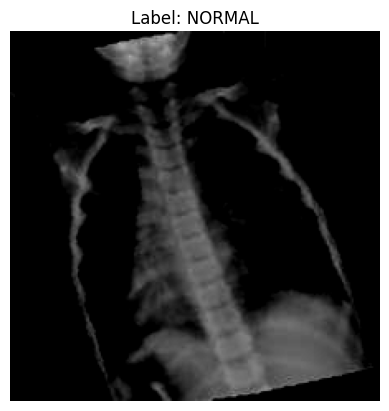

In [38]:
%run load_and_preprocess_data.ipynb

### **_MODEL_**

In [ ]:
# model = models.resnet18(pretrained=True)  # Prefabricated ResNet18 load
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 2)  # 2 Outputs (NORMAL vs PNEUMONIA)


model = models.densenet121(pretrained=True)  # Prefabricated ResNet18 load
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2) # 2 Outputs (NORMAL vs PNEUMONIA)

C:\Users\finnr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\finnr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **_Gridsearch_**

Use of Gridseach for optimal parameters for DensNet model

In [ ]:
class DenseNetModel(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNetModel, self).__init__()
        self.model = models.densenet121(pretrained=True)
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
# skorch-Classification model
net_classifier = NeuralNetClassifier(
    module=DenseNetModel,
    module__num_classes=2,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    train_split=None,
    max_epochs=5,
)

In [ ]:
# Konvertiere train_dataset in X_train und y_train
X_train = []
y_train = []

# for x, y in train_loader:
#     X_train.append(x.numpy())  # Falls nötig, in NumPy umwandeln
#     y_train.append(y.numpy())

# # In NumPy-Arrays umwandeln
# X_train = np.concatenate(X_train, axis=0)
# y_train = np.concatenate(y_train, axis=0)

param_grid_classifier = {
    'lr': [0.001, 0.0001],
    'batch_size': [16, 32],
    'module__num_classes': [2],
    'optimizer': [optim.Adam, optim.SGD]
}

gs_classifier = GridSearchCV(net_classifier, param_grid_classifier, cv=3, scoring='accuracy', verbose=1)

# Führe GridSearch durch (beachte: jetzt mit X_train und y_train)
# gs_classifier.fit(X_train, y_train)

# print("Beste Parameter Klassifikation:", gs_classifier.best_params_)


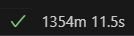

Best parameters: {'batch_size': 32, 'lr': 0.0001, 'module__num_classes': 2, 'optimizer': <class 'torch.optim.adam.Adam'>}

The problem here is the lack of computing power to be able to optimise the parameters even more precisely!

### **_Train Model_**

In [43]:
min_val_loss = float('inf')
early_stop = 4
epochs = 10
learning_rate = 0.00005
weights = torch.tensor([1.5, 1.0])  # Increases weight for ‘NORMAL’ class

criterion = CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

In [44]:
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # === Validierung ===
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs = model(x_batch)
            val_losses.append(criterion(outputs, y_batch).item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

    if early_stop_count >= early_stop:
        print("Early stopping!")
        break

Epoch 1/10, Validation Loss: 0.0582
Epoch 2/10, Validation Loss: 0.3892
Epoch 3/10, Validation Loss: 0.0104
Epoch 4/10, Validation Loss: 0.0054
Epoch 5/10, Validation Loss: 0.2400
Epoch 6/10, Validation Loss: 0.2403
Epoch 7/10, Validation Loss: 0.0186
Epoch 8/10, Validation Loss: 0.0565
Early stopping!


### **_Test Model_**

In [45]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 82.69%


DenseBased: Test Accuracy: 80.29%

- bachsize = 16, adam, lr=0,0001: 81.89%

- bachsize = 16, adam, lr=0,00005: 82.69%


- bachsize = 32, adam, lr=0,0001: 79.81%

### **_Evaluation_**

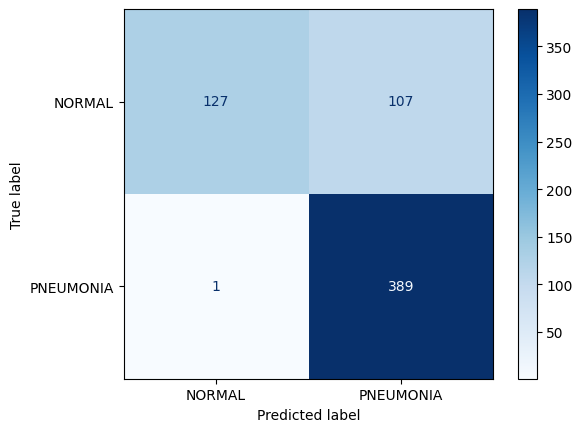

In [ ]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [47]:
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


              precision    recall  f1-score   support

      NORMAL       0.99      0.54      0.70       234
   PNEUMONIA       0.78      1.00      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.77      0.79       624
weighted avg       0.86      0.83      0.81       624



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input da

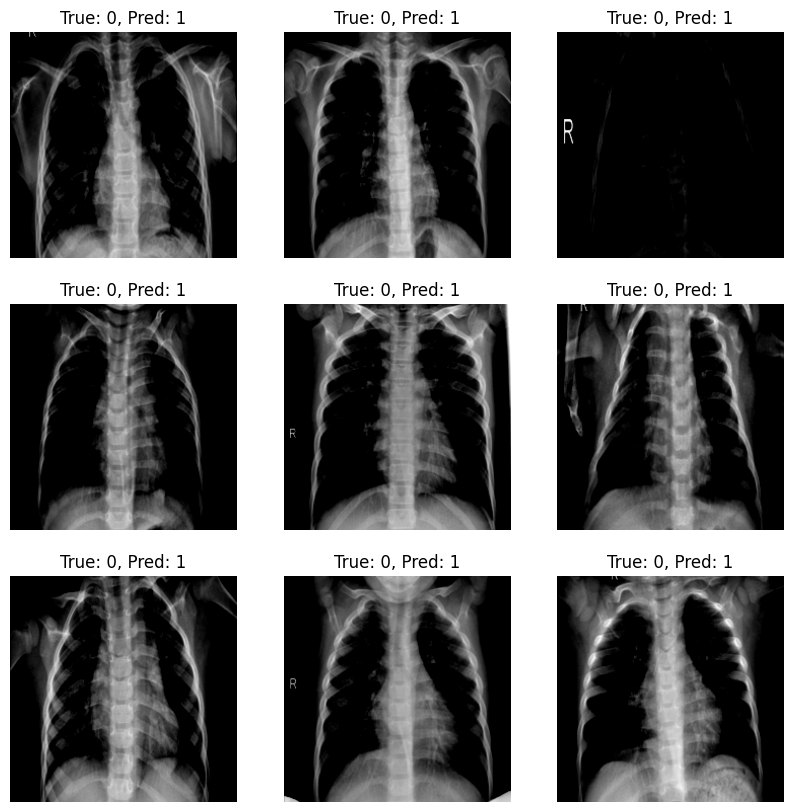

In [48]:
misclassified = []
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)
        
        for i in range(len(y_batch)):
            if predicted[i] != y_batch[i]:
                misclassified.append((x_batch[i], y_batch[i], predicted[i]))

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (image, true_label, pred_label) in enumerate(misclassified[:9]):
    ax = axes[i // 3, i % 3]
    ax.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    ax.set_title(f"True: {true_label}, Pred: {pred_label}")
    ax.axis("off")

plt.show()
